# Data Modelisation

- Configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from nlp_module import remove_stopwords, plot_top_words, tok, print_evaluation_scores
import sklearn
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis
import pyLDAvis.sklearn

In [2]:
sklearn.set_config(display="diagram")

## 1) Data preparation

In [3]:
path = "datasets/posts_clean.csv"

In [4]:
data = pd.read_csv(path)
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,I use python year I little experience python w...,<python><web-services>
1,415344,log implementation prefer,I implement log class c try decide I curious k...,<debugging><language-agnostic><logging>
2,414981,directly modify list element,I struct struct map public int size public map...,<c#><.net>


Our data is composed by title of the posts, body and associated tags. As we can see, our data needs a bit of preprocessing. In one hand, signs "<" and ">" will be remove and in other hand, texts inside body will be written in lower case and stopwords will be removed. 

In [5]:
# remove < and > around Tags
data["Tags"] = data["Tags"].replace({"<" : " "}, regex=True)
data["Tags"] = data["Tags"].replace({">" : " "}, regex=True)

In [6]:
data["Body"] = data["Body"].str.lower()
data["Body"] = data["Body"].apply(remove_stopwords)

Missing data will be inspected again. Indeed, we haven't watched missing values for titles yet. 

In [7]:
data.isnull().mean()

Id       0.000000
Title    0.000061
Body     0.000000
Tags     0.000000
dtype: float64

In [8]:
data.dropna(inplace=True)

Missing values for titles represent less than 1% of our dataset. We can delete them. 

In [9]:
data.head(3)

,Id,Title,Body,Tags
0,415192,good way create simple python web service,use python year little experience python web p...,python web-services
1,415344,log implementation prefer,implement log class c try decide curious know ...,debugging language-agnostic logging
2,414981,directly modify list element,struct struct map public int size public map i...,c# .net


Our dataset is ready for the next step. Before, data will be resampling. In order to accelerate the modeling's stages, only 10% of our data will be used.

In [10]:
data = data.sample(frac=0.1, random_state=42)

Moreover, we decide to consider title and body as a whole text. We aggregate these data in a new variable nammed "docs". 

In [11]:
docs = data["Title"].values + " " + data["Body"].values

Finally, we can vectorize our data. In order to realise a first classification with NMF, the chosen vectorizer is TF-IDF. The sparsicity of our vectorized data is evaluated. 

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_features=12000)
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [13]:
data_dense = tfidf.todense()
print("Sparsicity: ", (((data_dense > 0).sum()/data_dense.size)*100).round(3), "%")

Sparsicity:  0.408 %


Sparsicity is less than 1%.

## 2) Topic Modelling

Topic Modelling is an unsupervised method. These methods are used in order to find a classification inside our text. 

### a) Non Negative Matrix Factorization (NMF)

In [14]:
best_num_topics = 10

In [15]:
nmf = NMF(n_components=best_num_topics,
          random_state=42,
          alpha=0.1)

In [16]:
nmf.fit(tfidf)

NMF(alpha=0.1, n_components=10, random_state=42)

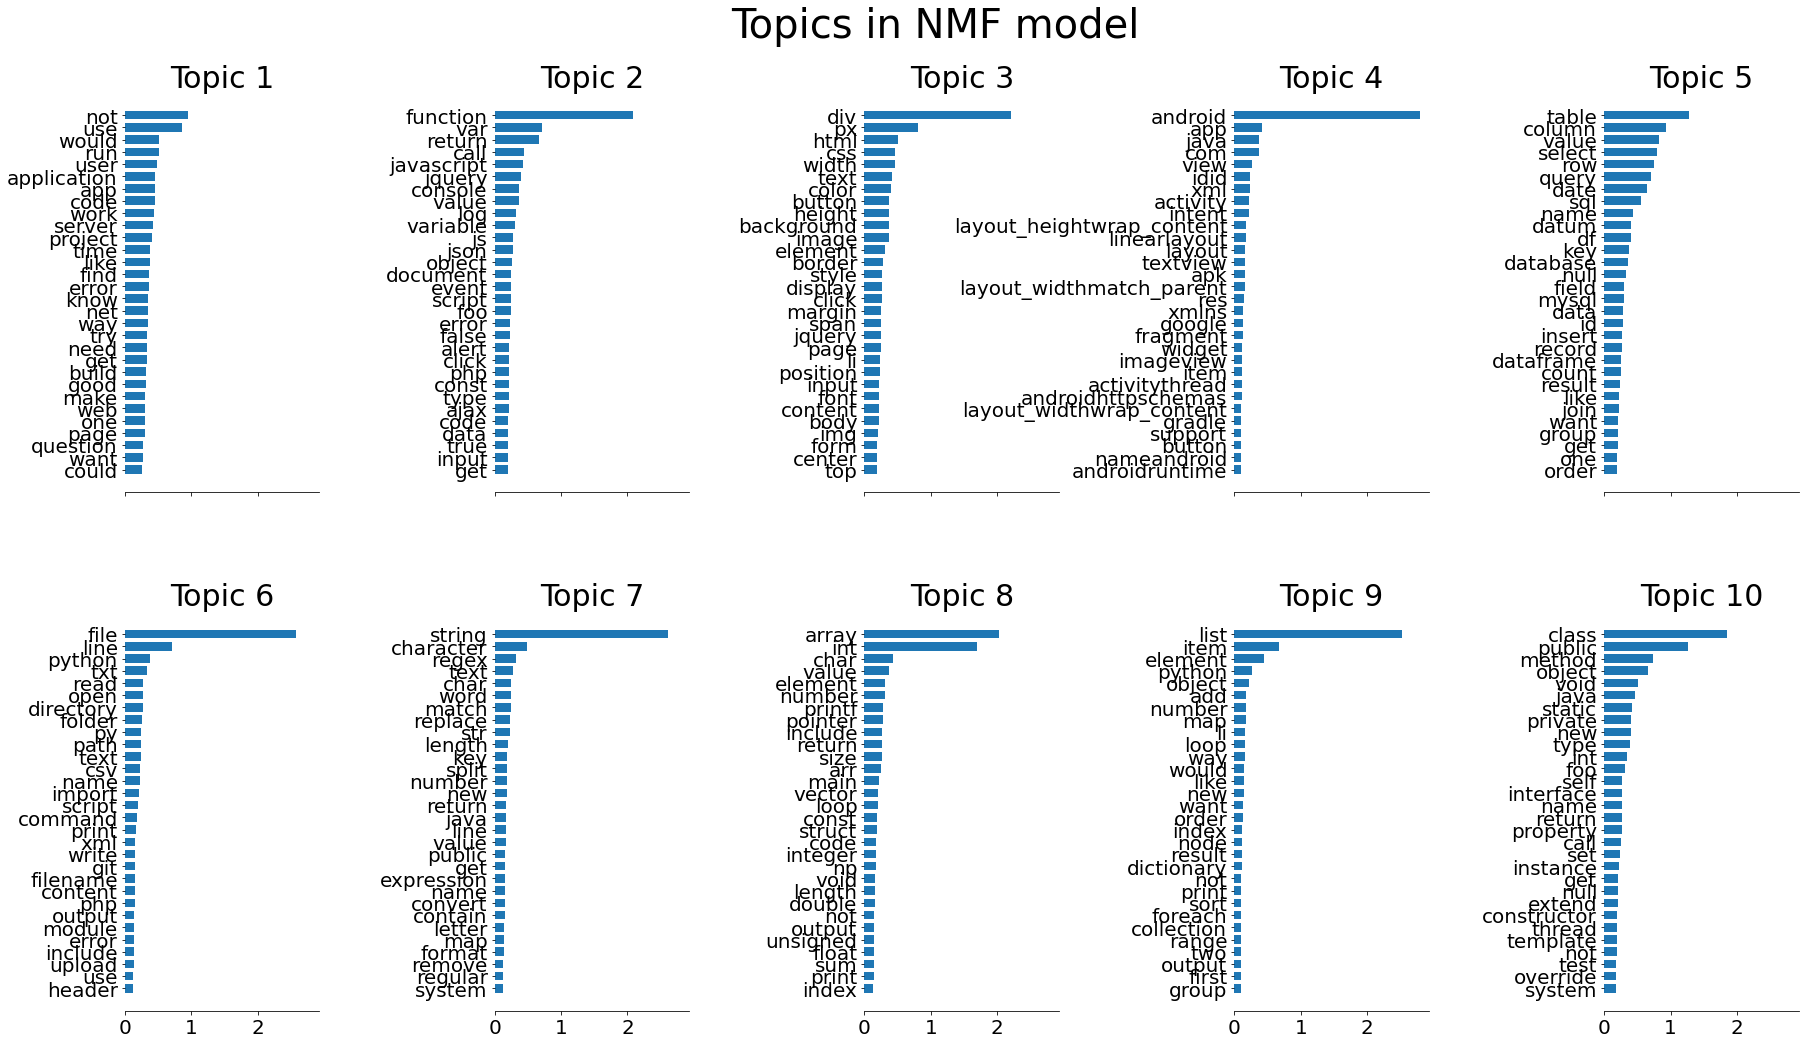

In [17]:
plot_top_words(nmf, tfidf_feature_names, n_top_words=30, title="Topics in NMF model")

### b) Latent Dirichlet Allocation (LDA)

In [18]:
bow_vectorizer = CountVectorizer(ngram_range = (1,1),
                                 tokenizer=tok)
docs_bow = bow_vectorizer.fit_transform(docs)

In [19]:
lda = LatentDirichletAllocation(random_state=42,
                                batch_size=400)

In [20]:
params = {'n_components' : [8, 9, 10],
          "learning_decay" : [0.5, 0.7, 0.9],
          "learning_method" : ["batch", "online"]}

gridsearch_lda = GridSearchCV(lda,
                              param_grid=params,
                              cv=5,
                              verbose=2)
gridsearch_lda.fit(docs_bow)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  43.4s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  43.5s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  42.5s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  42.9s
[CV] END learning_decay=0.5, learning_method=batch, n_components=8; total time=  42.9s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  43.5s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  43.5s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  42.9s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  42.1s
[CV] END learning_decay=0.5, learning_method=batch, n_components=9; total time=  42.6s
[CV] END learning_decay=0.5, learning_method=batch, n_components=10; 

GridSearchCV(cv=5,
             estimator=LatentDirichletAllocation(batch_size=400,
                                                 random_state=42),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['batch', 'online'],
                         'n_components': [8, 9, 10]},
             verbose=2)

In [21]:
best_lda_model = gridsearch_lda.best_estimator_

print("Best Model's Params: ", gridsearch_lda.best_params_)
print("Best Log Likelihood Score: ", gridsearch_lda.best_score_)

Best Model's Params:  {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 8}
Best Log Likelihood Score:  -3678711.326789887


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, docs_bow, bow_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0     -108.958252 -208.941483       1        1  48.139513
7      186.487061  -98.103249       2        1  19.514100
4       19.245832  160.858780       3        1   9.427921
1      170.658829   75.445076       4        1   7.923293
3       -1.386411  -35.043739       5        1   6.326914
5     -145.800095  106.944611       6        1   4.863240
2       64.834541 -221.825272       7        1   2.036737
6     -196.906036  -58.990913       8        1   1.768283, topic_info=          Term          Freq         Total Category  logprob  loglift
850          ]  30427.000000  30427.000000  Default  30.0000  30.0000
2            [  20666.000000  20666.000000  Default  29.0000  29.0000
5070   android   6743.000000   6743.000000  Default  28.0000  28.0000
960          _   9177.000000   9177.000000  Default  27.0000  27.0000
52137     java   7148.000000   7148.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
28328      dll     35.222192    438.183051   Topic8  -6.8721   1.5142
6303      arch     29.555454     90.811143   Topic8  -7.0475   2.9126
7877      auto     32.185765    778.332032   Topic8  -6.9622   0.8495
55520      lib     32.030142   1347.876177   Topic8  -6.9671   0.2956
2818        ad     29.988446    179.671343   Topic8  -7.0329   2.2448

[638 rows x 6 columns], token_table=        Topic      Freq    Term
term                           
0           1  0.001230     &#9
0           3  0.997454     &#9
0           7  0.001230     &#9
1           1  0.001230       ;
1           3  0.996254       ;
...       ...       ...     ...
109226      5  0.994670     xsd
109241      1  0.011269     xsl
109241      3  0.005634     xsl
109241      5  0.980391     xsl
109484      8  0.946409  xy_pod

[1862 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 5, 2, 4, 6, 3, 7])

- Topic 1 : OS - Top topic
- Topic 2 : Script Language/Python
- Topic 3 : Web language/Front-end
- Topic 4 : Java
- Topic 5 : Web language/Back-end
- Topic 6 : SQL
- Topic 7 : Script Language

## 3) Supervised learning for text classification

- CRF (Conditional Random Fields)
- Données séquentielles

In [25]:
tags = data[["Id", "Tags"]]

In [26]:
tags = tags["Tags"].str.split(expand=True)
tags['Id'] = data["Id"]
tags.columns = ["1st", "2nd", "3rd", "4th", "5th", "Id"]
tags = tags[["Id", "1st", "2nd", "3rd", "4th", "5th"]]
tags.head()

,Id,1st,2nd,3rd,4th,5th
73660,1709216,c,yaml,None,None,None
35316,11233449,javascript,twitter-bootstrap,None,None,None
28719,6376571,c#,None,None,None,None
149862,61548934,java,spring-boot,docker,maven,None
13680,2652816,javascript,None,None,None,None


In [27]:
tags.fillna("",inplace=True)

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

new_tags=pd.DataFrame(mlb.fit_transform(tags[["1st", "2nd", "3rd", "4th", "5th"]].values),
                      columns=mlb.classes_,
                      index=tags["Id"])

In [29]:
from sklearn.model_selection import train_test_split

X = docs
y = new_tags

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

### a) Support Vector Machine

In [28]:
vectorizer = TfidfVectorizer(ngram_range =(1,1),
                            tokenizer=tok,
                            max_features=12000)
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)

In [29]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

svm_clf = OneVsRestClassifier(SVC(random_state=42))
svm_clf.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=SVC(random_state=42))

In [30]:
X_test_vec = vectorizer.transform(X_test)
y_pred = svm_clf.predict(X_test_vec)

In [31]:
print_evaluation_scores(y_test, y_pred)

Accuracy:  225
F1-score macro:  0.005960707580228989
F1-score micro:  0.4985352862849534
F1-score weighted:  0.377605013444355
Precision macro:  nan
Precision micro:  0.3020058501701957
Precision weighted:  0.31374224599237704
Recall macro:  0.004209399084636847
Recall micro:  0.35117558779389696
Recall weighted:  0.35117558779389696


- Grid Search CV

In [32]:
from sklearn.metrics import make_scorer, f1_score

scorer_multilabel = make_scorer(f1_score,
                                average="weighted")

In [36]:
params = {"estimator__C": [1, 10, 100],
          "estimator__gamma": [0.001, 0.0001],
          "estimator__class_weight" : ["balanced"]}

gridsearch_svm = GridSearchCV(estimator=svm_clf, 
                             param_grid=params, 
                             scoring=scorer_multilabel,
                             cv=5,
                             verbose=2)
gridsearch_svm.fit(X_train_vec, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
gridsearch_svm.best_estimator_

In [ ]:
gridsearch_svm.best_params_

In [ ]:
best_model_svm = gridsearch_svm.best_estimator_

- Model Evaluation

In [ ]:
y_pred = best_model_svm.predict(X_test_vec)

In [ ]:
print_evaluation_scores(y_test, y_pred)

### b) Naive Bayes Classifier

In [37]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, 
                                           class_prior=None))
nb_clf.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [38]:
y_pred_nb = nb_clf.predict(X_test_vec)

In [39]:
print_evaluation_scores(y_test, y_pred_nb)

Accuracy:  12
F1-score macro:  0.0002776710350796119
F1-score micro:  0.36246178124075357
F1-score weighted:  0.22030887261297052
Precision macro:  nan
Precision micro:  0.19746222590105605
Precision weighted:  0.21422156440630166
Recall macro:  0.00022334593500654312
Recall micro:  0.2298024012006003
Recall weighted:  0.2298024012006003


- Grid Search

In [40]:
params = {"estimator__alpha": [0.3, 0.5, 0.7, 0.9, 1.0]}

gridsearch_nb = GridSearchCV(estimator=nb_clf, 
                             param_grid=params, 
                             scoring=scorer_multilabel,
                             cv=5,
                             verbose = 2)
gridsearch_nb.fit(X_train_vec, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...............................estimator__alpha=0.3; total time=  27.9s
[CV] END ...............................estimator__alpha=0.3; total time=  27.7s
[CV] END ...............................estimator__alpha=0.3; total time=  27.2s
[CV] END ...............................estimator__alpha=0.3; total time=  27.1s
[CV] END ...............................estimator__alpha=0.3; total time=  27.9s
[CV] END ...............................estimator__alpha=0.5; total time=  27.1s
[CV] END ...............................estimator__alpha=0.5; total time=  26.1s
[CV] END ...............................estimator__alpha=0.5; total time=  27.2s
[CV] END ...............................estimator__alpha=0.5; total time=  28.0s
[CV] END ...............................estimator__alpha=0.5; total time=  25.6s
[CV] END ...............................estimator__alpha=0.7; total time=  26.2s
[CV] END ...............................estimator

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=MultinomialNB()),
             param_grid={'estimator__alpha': [0.3, 0.5, 0.7, 0.9, 1.0]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [41]:
gridsearch_nb.best_estimator_

OneVsRestClassifier(estimator=MultinomialNB(alpha=0.3))

In [42]:
gridsearch_nb.best_params_

{'estimator__alpha': 0.3}

In [43]:
best_model_nb = gridsearch_nb.best_estimator_

- Model Evaluation

In [44]:
y_pred_nb = best_model_nb.predict(X_test_vec)

In [45]:
print_evaluation_scores(y_test, y_pred_nb)

Accuracy:  50
F1-score macro:  0.000782848993298081
F1-score micro:  0.4003632713541418
F1-score weighted:  0.2678629906392363
Precision macro:  nan
Precision micro:  0.2229134521790663
Precision weighted:  0.23828270473759053
Recall macro:  0.0005509268090588089
Recall micro:  0.26188094047023514
Recall weighted:  0.26188094047023514


## 4) Deep Learning for text classification

#### a) Using LSTM

In [86]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import convert_to_tensor

In [87]:
tokenizer = Tokenizer(num_words=12000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [32]:
X_train = pad_sequences(X_train)
print('Shape of data tensor:', X_train.shape)

Shape of data tensor: (12344, 3329)


In [33]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test)
print("Shape of data tensor:", X_test.shape)

Shape of data tensor: (4115, 1937)


In [88]:
y_train = convert_to_tensor(y_train)
print("Shape of data tensor:", y_train.shape)

Shape of data tensor: (12344, 7130)


In [89]:
y_test = convert_to_tensor(y_test)
print("Shape of data tensor:", y_test.shape)

Shape of data tensor: (4115, 7130)


- LSTM

In [124]:
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.optimizers import Adam

In [130]:
def LSTM_model():
    model = Sequential()
    model.add(Embedding(input_dim=12344, output_dim=5))
    model.add(SpatialDropout1D(0.1))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(64, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', 
              optimizer = Adam(1e-4), 
              metrics = ['accuracy'])
    return model

In [ ]:
model = LSTM_model()

In [131]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, None, 5)           61720     
_________________________________________________________________
spatial_dropout1d_29 (Spatia (None, None, 5)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 128)               35840     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
Total params: 105,816
Trainable params: 105,816
Non-trainable params: 0
_________________________________________________________________


In [127]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/5


ValueError: in user code:

    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\cecil\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 7130) and (None, 64) are incompatible


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

- Word2vec

In [ ]:
documents = 

In [ ]:
sentences = [[word for word in document.lower().split()] for document in documents]

In [ ]:
word_model = gensim.models.Word2Vec(sentences, vector_size=100, min_count=1, 
                                    window=5, iter=100)